In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology as morph
import skimage.filters as filters
import skimage.exposure as exposure
import skimage.feature as feature
from skimage import color
from skimage.feature import greycomatrix, greycoprops

In [3]:
def adjust_gamma(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

def microaneurysm(img):
    r,g,b=cv2.split(img)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening

In [114]:
def exudate(img):
    # green channel
    green = img[:,:,1]
    # clahe
    clahe = cv2.createCLAHE()
    cl1 = clahe.apply(green)
    # dilate
    dilation = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    dilated = cv2.dilate(cl1,dilation)
    # threshold
    ret,thresh = cv2.threshold(dilated, 220, 220, cv2.THRESH_BINARY)
    # median filter
    median = cv2.medianBlur(thresh, 5)


    return median

In [57]:
def colorChannel(img):
    img = cv2.resize(img, (500, 500))
    # red image
    # red = img[:, :, 2]
    # green image
    # green = img[:, :, 1]
    # # blue image
    # blue = img[:, :, 0]
    # hsv image
    # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # # hue image
    # hue = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 0]
    # # saturation image
    # saturation = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 1]
    # # value image
    # value = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 2]
    # cielab image
    cielab = color.rgb2lab(img)
    # cielab L image
    cielab_L = color.rgb2lab(img)[:, :, 0]
    # cielab a image
    cielab_a = color.rgb2lab(img)[:, :, 1]
    # cielab b image
    cielab_b = color.rgb2lab(img)[:, :, 2]
    # rgb2ycbcr
    ycbcr = color.rgb2ycbcr(img)
    # ycbcr y image
    ycbcr_y = color.rgb2ycbcr(img)[:, :, 0]
    # ycbcr cb image
    ycbcr_cb = color.rgb2ycbcr(img)[:, :, 1]
    # ycbcr cr image
    ycbcr_cr = color.rgb2ycbcr(img)[:, :, 2]

    return ycbcr_cr

In [71]:
def bloodVessel(img):
	img = cv2.resize(img, (500, 500))
	green = img[:,:,1]
	createClahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	clahe = createClahe.apply(green)

	# applying alternate sequential filtering (3 times closing opening)
	r1 = cv2.morphologyEx(clahe, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)	
	f4 = cv2.subtract(R3,clahe)
	f5 = createClahe.apply(f4)		

	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255
	contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood
	# vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)	
	xmask = np.ones(img.shape[:2], dtype="uint8") * 255
	xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   				
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)	

	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	blood_vessels = cv2.bitwise_not(finimage)
	return blood_vessels

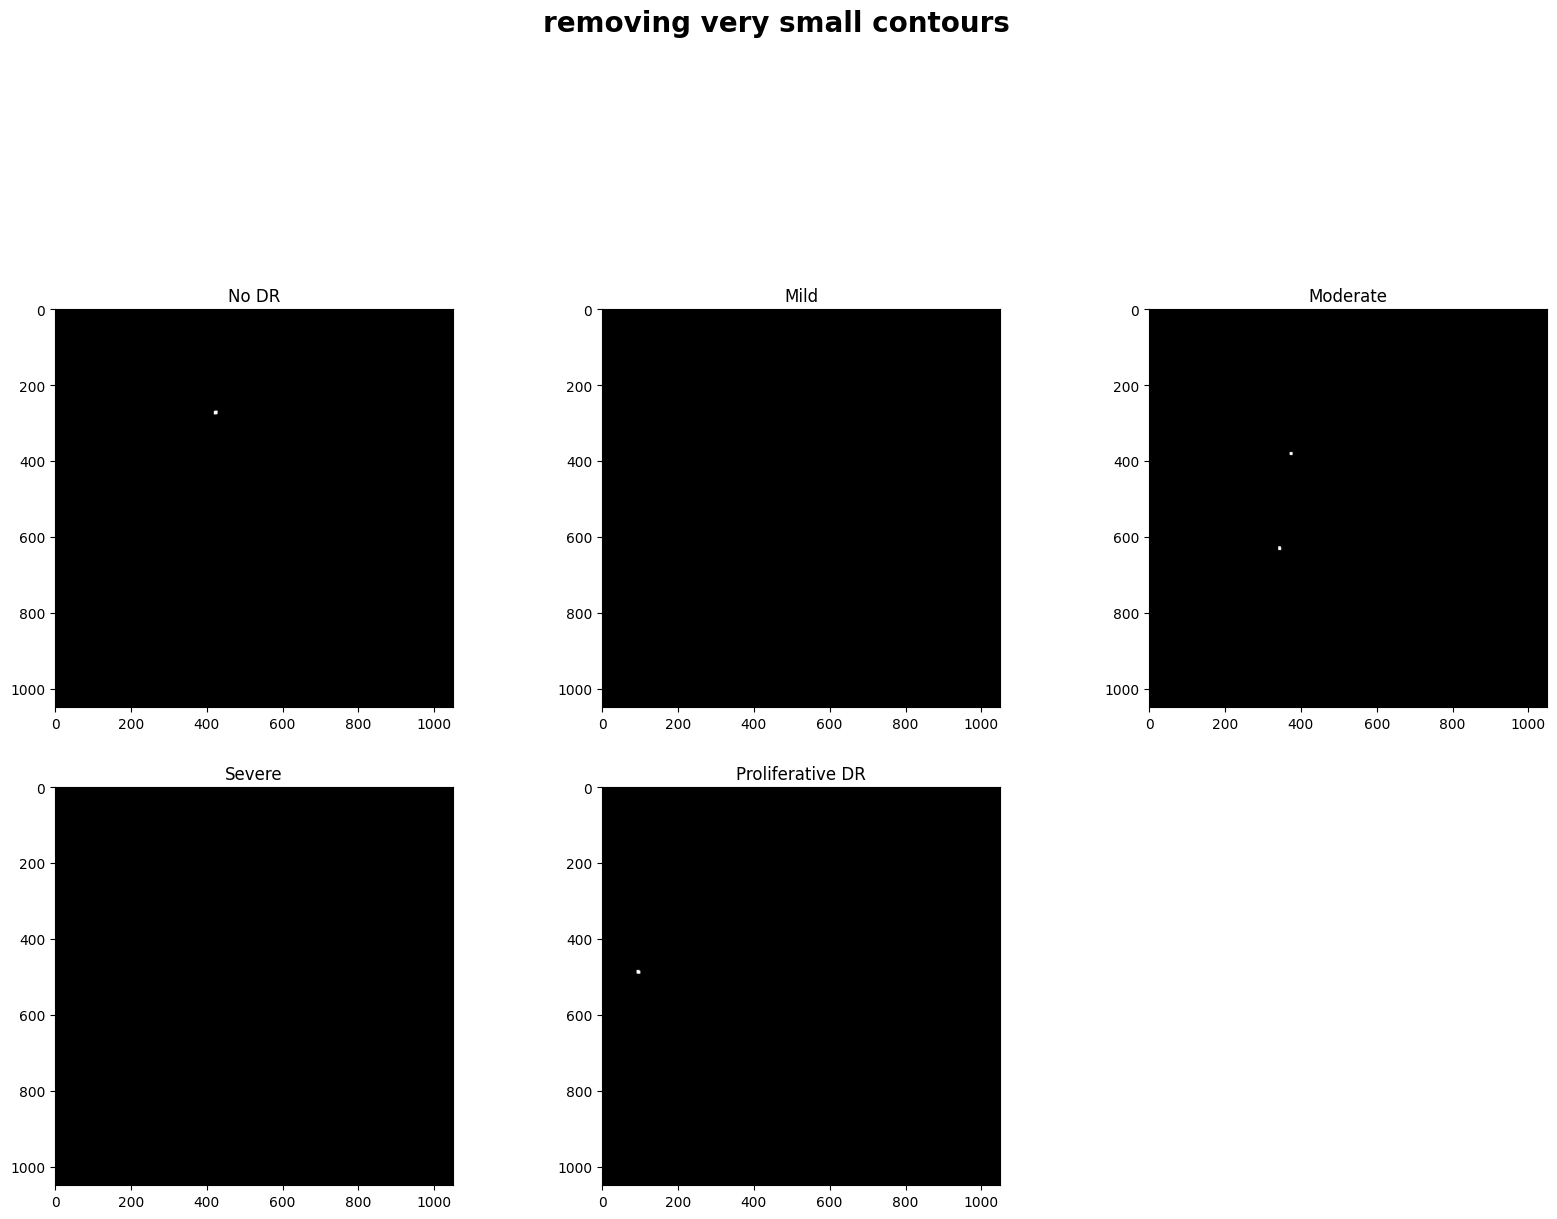

In [4]:
img0 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/0/00cc2b75cddd.png')
img1 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/1/38e0e28d35d3.png')
img2 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/2/3f5b4c2948e8.png')
img3 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/3/8688f3d0fcaf.png')
img4 = cv2.imread('E:/Pawang Code/Diabetic Retinopathy/dataset/4/613028ede6a0.png')

# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
# img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

img0 = microaneurysm(img0)
img1 = microaneurysm(img1)
img2 = microaneurysm(img2)
img3 = microaneurysm(img3)
img4 = microaneurysm(img4)

plt.figure(figsize=(20, 30))
plt.suptitle('removing very small contours', fontsize=20, fontweight='bold')
plt.subplot(5, 3, 1)
plt.title('No DR')
plt.imshow(img0, cmap='gray', vmin=0, vmax=255)
plt.subplot(5, 3, 2)
plt.title('Mild')
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.subplot(5, 3, 3)
plt.title('Moderate')
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.subplot(5, 3, 4)
plt.title('Severe')
plt.imshow(img3, cmap='gray', vmin=0, vmax=255)
plt.subplot(5, 3, 5)
plt.title('Proliferative DR')
plt.imshow(img4, cmap='gray', vmin=0, vmax=255)

In [101]:
img0 = cv2.imread('D:/Pawang Code/Diabetic Retinopathy/dataset/0/00cc2b75cddd.png')
img1 = cv2.imread('D:/Pawang Code/Diabetic Retinopathy/dataset/1/38e0e28d35d3.png')
img2 = cv2.imread('D:/Pawang Code/Diabetic Retinopathy/dataset/2/3f5b4c2948e8.png')
img3 = cv2.imread('D:/Pawang Code/Diabetic Retinopathy/dataset/3/8688f3d0fcaf.png')
img4 = cv2.imread('D:/Pawang Code/Diabetic Retinopathy/dataset/4/613028ede6a0.png')

img0 = bloodVessel(img0)
img1 = bloodVessel(img1)
img2 = bloodVessel(img2)
img3 = bloodVessel(img3)
img4 = bloodVessel(img4)

cv2.imwrite('C:/Users/user/Documents/Python/DiabeticRetinopathy/0.png', img0)
cv2.imwrite('C:/Users/user/Documents/Python/DiabeticRetinopathy/1.png', img1)
cv2.imwrite('C:/Users/user/Documents/Python/DiabeticRetinopathy/2.png', img2)
cv2.imwrite('C:/Users/user/Documents/Python/DiabeticRetinopathy/3.png', img3)
cv2.imwrite('C:/Users/user/Documents/Python/DiabeticRetinopathy/4.png', img4)

# cv2.imshow('img0', img0)
# cv2.imshow('img1', img1)
# cv2.imshow('img2', img2)
# cv2.imshow('img3', img3)
# cv2.imshow('img4', img4)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
def glcm(img):
    glcm_feature = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    distance = [5]
    angles = [0]
    level = 256
    symetric = True
    normed = True

    glcm = greycomatrix(img, distance, angles, level, symmetric=symetric, normed=normed)
    glcm_props = [property for name in glcm_feature for property in greycoprops(glcm, name)[0]]

    return glcm_props

In [22]:
glcm0 = glcm(img0)
glcm1 = glcm(img1)
glcm2 = glcm(img2)
glcm3 = glcm(img3)
glcm4 = glcm(img4)

print(glcm0)
print(glcm1)
print(glcm2)
print(glcm3)
print(glcm4)

[12577.279999999999, 49.32266666666666, 0.8065807523144588, 0.48442494432812977, 0.6960064254934215, 0.46206603014461833]
[6968.052727272727, 27.325696969696967, 0.8928420519903928, 0.7337594071788593, 0.8565975759823625, 0.37173444884069684]
[8125.103636363637, 31.863151515151518, 0.8750483862399097, 0.719485945483114, 0.8482251738088855, 0.270019952888093]
[17595.370909090907, 69.00145454545455, 0.7294102219252159, 0.4447287150617284, 0.6668798355489004, 0.24393649132538436]
[15698.480000000001, 61.56266666666667, 0.7585814904807309, 0.4902527702234466, 0.7001805268810656, 0.26082347068600525]
